# Tutorial: Fine-Tuning Whisper for French Québecois Telephone Conversations

Before we dive into the hands-on steps, it’s helpful to understand **what** Whisper is and **why** you might need to adapt it for your own audio data.

## What is Whisper?

Whisper is a widely used open-source Automatic Speech Recognition (ASR) model but despite its wide adoption, the technical details of the model are less well known to some, which limits the contributions and innovations. For a deeper technical overview, see our Diabolocom blog post: [URL]

## Why fine-tune Whisper?

ASR systems like OpenAI’s Whisper deliver impressive out-of-the-box transcriptions by leveraging a vast, multilingual training dataset of audio and transcripts, see **Figure 1**, it still reflects the distribution of that original dataset.

However, when your use case involves specialized vocabulary or languages that were underrepresented during pretraining, fine-tuning can make a significant difference. In particular, if your data diverges from Whisper’s original training set, whether in domain, audio characteristics, or speaker demographics, adapting the model to your specific dataset could yields notable reductions in Word Error Rate (WER).

<img src="images/training_dataset.png" width="1000" />

_**Figure 1:** Whisper training dataset from **(Radford et al, 2022)**_

To illustrate Whisper’s existing breadth, here are the 57 languages for which it achieves a WER below 50% (an industry-standard threshold for “usable” transcripts):

> Afrikaans, Arabic, Armenian, Azerbaijani, Belarusian, Bosnian, Bulgarian, Catalan, Chinese, Croatian, Czech, Danish, Dutch, English, Estonian, Finnish, French, Galician, German, Greek, Hebrew, Hindi, Hungarian, Icelandic, Indonesian, Italian, Japanese, Kannada, Kazakh, Korean, Latvian, Lithuanian, Macedonian, Malay, Marathi, Māori, Nepali, Norwegian, Persian, Polish, Portuguese, Romanian, Russian, Serbian, Slovak, Slovenian, Spanish, Swahili, Swedish, Tagalog, Tamil, Thai, Turkish, Ukrainian, Urdu, Vietnamese, and Welsh.


Despite being pretrained on 98 languages, Whisper’s accuracy drops markedly on the 41 less-represented ones, highlighting the need for targeted fine-tuning for under-resourced dialects.
We now describe the procedure for adapting Whisper to Québecois telephone speech.

----------

## Tutorial Overview

We fine-tune the Whisper **medium** model on a French Québécois telephone speech dataset (`Maheshwari et al., 2024`). To keep GPU requirements low and limit trainable parameters, we integrate Low-Rank Adaptation (LoRA) (`Hu et al., 2021`) and use FlashAttention 2 (`Dao et al., 2023`) for faster training. Although this tutorial focuses on the medium model, the same approach applies to other sizes.

The following steps are covered:

1. **Dataset preparation**

2. **LoRA adapter integration**

3. **Training with FlashAttention 2**

4. **Evaluation** via Word Error Rate (WER)  

5. **Deployment** with a Gradio demo

The full notebook and environment setup instructions are available on GitHub:  
https://github.com/Diabolocom-Research/Blogs  


### Initialization & Authentication

Set your model identifiers and language parameters. Then authenticate with Hugging Face so you can download models and optionally push your adapter checkpoint.

In [1]:
model_name_or_path = "openai/whisper-medium"
language = "French"
language_abbr = "fr"
task = "transcribe"

Your Hugging Face token can be found in [Hugging Face Hub.](https://huggingface.co/settings/tokens)

In [2]:
import os
from huggingface_hub import login

login()

### Data Loading

We retrieve the French Québecois telephone speech-to-text dataset (`diabolocom/talkbank_4_stt`) from the Hugging Face Hub. This dataset is organized into language-specific subsets with “segment” and “switch” splits; here, we select the Québecois “segment” split and resample all audio to 16 kHz.


In [3]:
from datasets import load_dataset, DatasetDict, Audio

talkbank = load_dataset("diabolocom/talkbank_4_stt", "fr", split="segment[:100%]")
talkbank = talkbank.cast_column("audio", Audio(sampling_rate=16000))

talkbank

Dataset({
    features: ['audio', 'transcript', 'language_code', 'subset', 'full_language', 'switch_id', 'segment_id', 'transcript_filename', 'audio_len_sec', 'orig_file_start', 'orig_file_end', 'channel', 'speaker_id'],
    num_rows: 14796
})

### Explore the dataset

Let’s listen to a sample, inspect its duration and metadata, and plot the distribution of audio lengths in train vs. test.

In [4]:
def format_seconds(seconds_input):
    """
    Turn a number of seconds (possibly fractional) into a compact string,
    omitting zero-value day/hour/minute units, and always showing seconds (with
    up to millisecond precision, dropping trailing zeros).
    """
    remaining = float(seconds_input)
    parts = []
    for label, unit_secs in (("d", 86400), ("h", 3600), ("m", 60)):
        qty, remaining = divmod(remaining, unit_secs)
        if qty >= 1:
            parts.append(f"{int(qty)}{label}")
    parts.append(f"{remaining:.3f}s")
    
    return " ".join(parts)

You can listen to other examples by changing the `sample_id` variable to any valid index in the dataset:

In [5]:
import torch
from datasets import Audio
import IPython.display as ipd

sample_id = 100
example = talkbank[sample_id]

audio_array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

ipd.display(ipd.Audio(audio_array, rate=sampling_rate))

print(f"Duration: {format_seconds(audio_array.shape[0]/sampling_rate)}")
print(f"Language: {example['full_language']}")
print(f"subset: {example['subset']}")
print(f"Transcript: {example['transcript']}")

Duration: 2.660s
Language: call_friend
subset: ca
Transcript: Tu regardera mais qu'ils fasse des gros vent à la tour à ton chum . 


### Preprocessing

In [6]:
# Just clean up unneeded columns, keeping the audio and transcript
talkbank = talkbank.remove_columns([
    "language_code", "subset", "full_language",
    "switch_id", "transcript_filename", "orig_file_start",
    "orig_file_end", "channel"
])

talkbank

Dataset({
    features: ['audio', 'transcript', 'segment_id', 'audio_len_sec', 'speaker_id'],
    num_rows: 14796
})

We first trim our dataset to only those utterances whose audio is between 1 second and 30 seconds long, and then we drop any transcripts whose tokenized length exceeds 448 tokens. This two-stage filtering is necessary because Whisper’s encoder was trained on speech segments up to 30 s, and its decoder cannot handle more than 448 output tokens in a single pass.

In [7]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path, language=language, task=task)

#Filter by duration in seconds (using the pre-computed field)
def filter_by_audio_length(example, min_sec=1.0, max_sec=30.0):
    return min_sec < float(example["audio_len_sec"]) < max_sec

talkbank = talkbank.filter(filter_by_audio_length)  # no input_columns)

#Filter out too-long transcripts the same as before:
from transformers import WhisperForConditionalGeneration
model = WhisperForConditionalGeneration.from_pretrained(model_name_or_path)
max_target_tokens = model.config.max_target_positions  # 448 by default

def filter_by_label_length(example):
    token_ids = tokenizer(example["transcript"]).input_ids
    return len(token_ids) <= max_target_tokens

# No input_columns means `example` is the full row dict:
talkbank = talkbank.filter(filter_by_label_length)

talkbank

Dataset({
    features: ['audio', 'transcript', 'segment_id', 'audio_len_sec', 'speaker_id'],
    num_rows: 12737
})

Next, we’ll split our filtered data into training and test sets:

In [8]:
# Create an 80/20 train-test split
talkbank = talkbank.train_test_split(test_size=0.2, seed=42)
talkbank = DatasetDict({"train": talkbank["train"], "test": talkbank["test"]})

talkbank

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcript', 'segment_id', 'audio_len_sec', 'speaker_id'],
        num_rows: 10189
    })
    test: Dataset({
        features: ['audio', 'transcript', 'segment_id', 'audio_len_sec', 'speaker_id'],
        num_rows: 2548
    })
})

The following plot illustrates the distribution of audio durations in both the training and test splits:

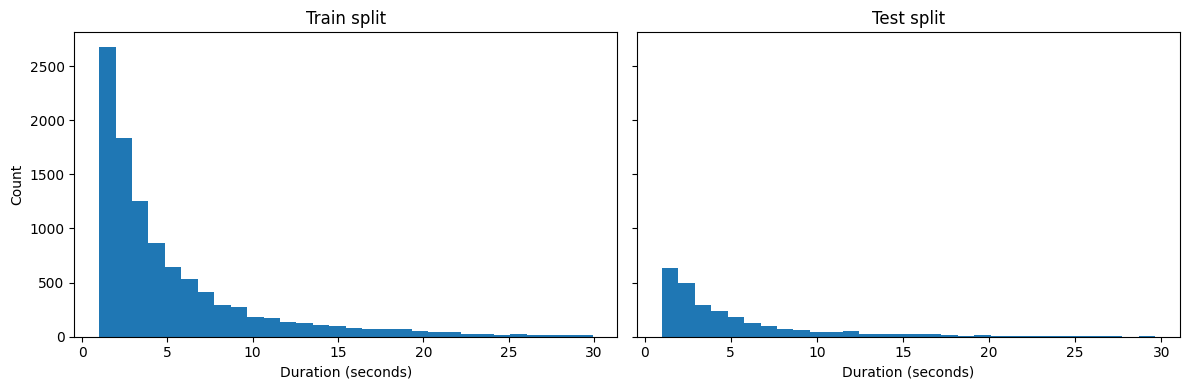

In [9]:
import matplotlib.pyplot as plt

durations = {}
for split in ["train","test"]:
    durations[split] = [
        ex["audio"]["array"].shape[0] / ex["audio"]["sampling_rate"]
        for ex in talkbank[split]
    ]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, split in zip(axes, ["train","test"]):
    ax.hist(durations[split], bins=30)
    ax.set_title(f"{split.capitalize()} split")
    ax.set_xlabel("Duration (seconds)")
axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()

Before we can fine-tune Whisper, we need to transform our raw dataset into exactly the inputs the model expects:  
1.  `input_features`: 80-dim log-Mel spectrogram frames.  
2.  `labels`: target tokenized transcripts.

We initialize Whisper’s feature extractor and tokenizer then define and apply a mapping function to generate model-ready inputs:

In [10]:
from transformers import WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path)

def prepare_dataset(batch):
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["transcript"]).input_ids
    return batch

talkbank = talkbank.map(prepare_dataset, remove_columns=talkbank.column_names["train"], num_proc=1)

talkbank['train']

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 10189
})

### Data collator

Our custom collator must handle two variable-length sequences:

1. **Input features**: the log-Mel spectrogram frames  
2. **Labels**: the target token IDs for the transcript

Steps:

- **Pad inputs and labels separately** to their own maximum lengths.  
- **Mask label padding** by replacing pad token IDs with `-100` so the loss function ignores them.  

In [11]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Pad the audio feature arrays
        input_feats = [{"input_features": f["input_features"]} for f in features]
        batch = self.processor.feature_extractor.pad(input_feats, return_tensors="pt")

        #Pad the transcript token IDs and mask padding tokens
        label_feats = [{"input_ids": f["labels"]} for f in features]
        labels_padded = self.processor.tokenizer.pad(label_feats, return_tensors="pt")
        labels = labels_padded["input_ids"].masked_fill(
            labels_padded.attention_mask.ne(1), -100
        )

        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

### Load the Pretrained Model and Tokenizer

We load the `WhisperForConditionalGeneration` model in 16-bit (FP16) precision to reduce GPU memory usage. By specifying `attn_implementation="flash_attention_2"`, we enable FlashAttention 2 for faster, more memory-efficient self-attention (which requires FP16 or BF16). The `device_map="auto"` option automatically distributes model layers across available devices.

After loading, we use `torchinfo.summary` to verify the model’s architecture and parameter counts.

In [12]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="flash_attention_2"
)

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
WhisperForConditionalGeneration                         --
├─WhisperModel: 1-1                                     --
│    └─WhisperEncoder: 2-1                              --
│    │    └─Conv1d: 3-1                                 246,784
│    │    └─Conv1d: 3-2                                 3,146,752
│    │    └─Embedding: 3-3                              (1,536,000)
│    │    └─ModuleList: 3-4                             302,284,800
│    │    └─LayerNorm: 3-5                              2,048
│    └─WhisperDecoder: 2-2                              --
│    │    └─Embedding: 3-6                              53,109,760
│    │    └─WhisperPositionalEmbedding: 3-7             458,752
│    │    └─ModuleList: 3-8                             403,070,976
│    │    └─LayerNorm: 3-9                              2,048
├─Linear: 1-2                                           53,109,760
Total params: 816,967,680
Trainable params: 

### Customizing Decoder Behavior

Once the model is loaded, you can control how Whisper seeds its decoder and which tokens it forbids by adjusting two configuration fields: `forced_decoder_ids` and `suppress_tokens`.

--

The `forced_decoder_ids` setting is a list of `[position, token_id]` pairs that Whisper will always emit at those decoder positions. It is typically used to preset the language and task.

**Default (English transcription):**

| Position | Token ID | Token               | Purpose                       |
|----------|----------|---------------------|-------------------------------|
| 1        | 50259    | `<\|en\|>`            | Force English language        |
| 2        | 50359    | `<\|transcribe\|>`    | Force transcription mode      |
| 3        | 50363    | `<\|notimestamps\|>`  | Omit timestamps in the output |

To switch to French transcription, generate a new set of prompts via the `WhisperProcessor`:

In [13]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    model_name_or_path,
    language=language,  # "French"
    task=task # "transcribe"
)

# Generate French decoder prompts
french_forced = processor.get_decoder_prompt_ids(language=language, task=task)
print("French forced_decoder_ids:", french_forced)
print(" -> Tokens and meanings:")
for pos, tid in french_forced:
    print(f"  Position {pos}: {tid} -> {tokenizer.convert_ids_to_tokens(tid)}")

French forced_decoder_ids: [(1, 50265), (2, 50359), (3, 50363)]
 -> Tokens and meanings:
  Position 1: 50265 -> <|fr|>
  Position 2: 50359 -> <|transcribe|>
  Position 3: 50363 -> <|notimestamps|>


`suppress_tokens` is a list of token IDs that Whisper will never sample (log-probability set to −∞). These include basic punctuation marks and internal markers ensuring clean natural-language output:

In [14]:
suppressed = model.config.suppress_tokens
print("suppress token ids:", suppressed)
print("suppress tokens:   ", tokenizer.convert_ids_to_tokens(suppressed))

suppress token ids: [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362]
suppress tokens:    ['"', '#', '(', ')', '*', '+', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', 'Ġ-', 'Ġ"', 'Ġ(', 'Ġ[', 'ĠâĻ', '>>', 'Ġ>>', '--', "Ġ'", 'ĠâĻª', 'Ġ--', 'Ġ*', 'Ġ:', 'Ġ/', 'Ġ<', 'ãĢĮ', 'ãĢį', 'âĻ', 'Ġ#', 'ĠâĻ«', 'âĻª', 'Ġ]', 'Ġ+', 'Ġ=', 'Ġ-(', 'Ġ)', 'ĠâĻªâĻª', '))', 'Ġ@', 'Ġ{', 'Ġ~', 'Ġ\\', 'Ġ>', 'Ġ;', 'Ġ>>>', 'âĻ«', 'Ġ-[', 'Ġ((', 'Ġ("', 'ãĢİ', 'ãĢı', 'Ġ|', 'Ġ^', '---', 'ĠãĢĮ', 'ĠâĻ¬', 'âĻªâĻª', 'Ġ_', 'Ġ)))', 'Ġ`', '}

## 8. LoRA fine-tuning

We will now integrate **LoRA adapters** into our pre-trained Whisper model via the PEFT library.

`LoRA (“Low-Rank Adaptation”)` freezes the original weights and learns only a small, **additive** low-rank update in selected layers. This reduces the number of trainable parameters and accelerates fine-tuning. 

Moreover, because the LoRA updates are stored separately, you can easily **swap in different adapter checkpoints**, for example, to support new languages or specialized domains while keeping the same underlying base model.

In [15]:
from peft import LoraConfig, get_peft_model, TaskType

# Configure LoRA settings for sequence-to-sequence language modeling
lora_config = LoraConfig(
    r=8,                           # Rank of the low-rank matrices
    lora_alpha=32,                  # Scaling factor for LoRA updates
    lora_dropout=0.1,               # Dropout probability for LoRA layers
    target_modules=["q_proj", "v_proj"]  # Target modules in the Transformer to adapt (adjust as needed)
)

#Some models freeze embeddings by default; this ensures LoRA can adapt them if needed.
model.enable_input_require_grads()

# Wrap the model with LoRA adapters; this makes only the LoRA parameters trainable.
model = get_peft_model(model, lora_config)

# Optionally, print trainable parameters to verify that only the LoRA layers are being updated.
print("Trainable parameters after applying LoRA:")
model.print_trainable_parameters()


Trainable parameters after applying LoRA:
trainable params: 2,359,296 || all params: 766,217,216 || trainable%: 0.3079


### Define the evaluation metric (WER)

We use the `Word Error Rate (WER)` to evaluate the performance of our speech recognition system.
The `compute_metrics` function decodes model predictions and ground-truth labels, computes the WER,
and returns it as a percentage.

In [16]:
import evaluate

# Load the WER metric from the evaluate library
metric = evaluate.load("wer")

def compute_metrics(pred):
    """
    Compute Word Error Rate (WER) for model predictions.
    
    Args:
        pred: The prediction output from the trainer containing predictions and label_ids.
    
    Returns:
        A dictionary containing the WER score.
    """
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Setup training arguments

We use Hugging Face's Seq2SeqTrainingArguments to define our training configuration.
These settings include batch size, learning rate, number of steps, evaluation strategy, and logging.


In [17]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="results",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=1e-3,
    warmup_steps=50,
    num_train_epochs=3,
    eval_strategy="epoch",
    fp16=True,
    per_device_eval_batch_size=16,
    generation_max_length=128,
    logging_steps=25,
    remove_unused_columns=False,  #required for the PeftModel forward
    label_names=["labels"],  #same reason as above
    report_to=["none"],  # Disable logging
    )   

### Initialize the Trainer

We instantiate Hugging Face's Seq2SeqTrainer with our model, training arguments, datasets and
data collator. 

In [18]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=talkbank["train"],
    eval_dataset=talkbank["test"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
)

/tmp/ipykernel_14022/613437022.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


### Fine-tune the Whisper model

We now start the training process. The trainer will fine-tune the model using the LoRA adapters,
updating only the LoRA-specific parameters.

We are using the medium Whisper model for demonstration, if you want production-quality transcription, increase the size of the Whisper model and fine-tuning it with a larger dataset.

In [19]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.870800,0.857296
2,0.733500,0.796819
3,0.565500,0.799219


TrainOutput(global_step=1911, training_loss=0.7803384081223197, metrics={'train_runtime': 5463.1376, 'train_samples_per_second': 5.595, 'train_steps_per_second': 0.35, 'total_flos': 3.130067811336192e+19, 'train_loss': 0.7803384081223197, 'epoch': 3.0})

**(Optional)** Push the model to a Hugging Face Hub repository of your choice.

In [20]:
peft_model_id = "diabolocom/" + f"{model_name_or_path}-LoRA".replace("/", "-")
model.push_to_hub(peft_model_id)
print(peft_model_id)

adapter_model.safetensors:   0%|          | 0.00/9.48M [00:00<?, ?B/s]

diabolocom/openai-whisper-medium-LoRA


**(Optional)** If later you need to reload your pushed LoRA model from the Hub:

In [21]:
from peft import PeftModel, PeftConfig
from transformers import WhisperForConditionalGeneration

# Load the fine-tuned LoRA model from the Hugging Face Hub
peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path, 
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="flash_attention_2",
)
model = PeftModel.from_pretrained(model, peft_model_id)

adapter_config.json:   0%|          | 0.00/897 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/9.48M [00:00<?, ?B/s]

### Evaluation

In this step, we compare our PEFT-LoRA–fine-tuned Whisper model against the original “medium” base model by running both on the test split and computing their Word Error Rate (WER).

In [22]:
from torch.utils.data import DataLoader

eval_dataloader = DataLoader(talkbank["test"], batch_size=16, collate_fn=data_collator)

# Generate token ids. We prompt the model with language and task information.
# The first few tokens of the labels tensor contain this prompt.
# e.g., [<|startoftranscript|>, <|fr|>, <|transcribe|>, <|notimestamps|>]
# This guides the model to generate in the correct language and format.

In [23]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import gc
import evaluate

# Load the base model
medium_model = WhisperForConditionalGeneration.from_pretrained(
    model_name_or_path,
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="flash_attention_2"
)

def evaluate_model(model, dataloader, tokenizer, model_name=None):
    """
    Evaluates a given model on a dataloader and computes the Word Error Rate (WER).
    """
    model.eval()
    metric = evaluate.load("wer")
    progress_bar = tqdm(dataloader, desc=f"Evaluating {model_name}")

    for batch in progress_bar:
        input_features = batch["input_features"].to(model.device, dtype=torch.float16)
        labels = batch["labels"].to(model.device)

        with torch.no_grad():
            prompt_ids = labels[:, :4]
            generated_tokens = model.generate(
                input_features=input_features,
                decoder_input_ids=prompt_ids,
            ).cpu().numpy()

            labels = labels.cpu().numpy()
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            metric.add_batch(predictions=decoded_preds, references=decoded_labels)

        gc.collect()
        torch.cuda.empty_cache()

    wer = 100 * metric.compute()
    return wer


#Evaluate the models to get the WER scores
lora_model_wer = evaluate_model(model, eval_dataloader, tokenizer, model_name="Fine-tuned Whisper medium with LoRA")
medium_model_wer = evaluate_model(medium_model, eval_dataloader, tokenizer, model_name="Whisper medium")

results_data = {
    "Model": ["Whisper medium", "Fine-tuned Whisper medium with LoRA"],
    "WER (%)": [medium_model_wer, lora_model_wer]
}

results_df = pd.DataFrame(results_data)

print("\n--- Evaluation Results ---")
print(results_df.to_string(index=False))
improvement = medium_model_wer - lora_model_wer
print(f"\nThe fine-tuned LoRA model shows an improvement of {improvement:.2f} WER points over the base model.")

Some parameters are on the meta device because they were offloaded to the cpu.
Evaluating Fine-tuned Whisper medium with LoRA:   0%|          | 0/160 [00:00<?, ?it/s]Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating Whisper medium: 100%|██████████| 160/160 [1:12:13<00:00, 27.08s/it]


--- Evaluation Results ---
                              Model   WER (%)
                     Whisper medium 77.376738
Fine-tuned Whisper medium with LoRA 45.738979

The fine-tuned LoRA model shows an improvement of 31.64 WER points over the base model.


## 14. Demonstration with Gradio

Here we build a simple web interface so users can speak into their microphone and see live transcription from our PEFT-LoRA Whisper model.

This French‐language Whisper-small model includes LoRA adapters to illustrate the fine-tuning process. 

It isn’t fully trained, if you want production-quality transcription, you should continue fine-tuning with a larger dataset and more training time.

In [31]:
import torch
import gradio as gr
from transformers import (
    AutomaticSpeechRecognitionPipeline,
    WhisperForConditionalGeneration,
    WhisperTokenizer,
    WhisperProcessor,
)
from peft import PeftModel, PeftConfig

peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(
    peft_config.base_model_name_or_path, 
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="flash_attention_2",
)
model = PeftModel.from_pretrained(model, peft_model_id)

tokenizer = WhisperTokenizer.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
processor = WhisperProcessor.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
feature_extractor = processor.feature_extractor
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task=task)
pipe = AutomaticSpeechRecognitionPipeline(model=model, tokenizer=tokenizer, feature_extractor=feature_extractor)


def transcribe(audio):
    with torch.cuda.amp.autocast():
        text = pipe(audio, generate_kwargs={"forced_decoder_ids": forced_decoder_ids}, max_new_tokens=255)["text"]
    return text

with gr.Blocks(css="""
    .banner { display:flex; flex-direction:column; align-items:center; margin-bottom:20px; }
    .banner img { max-width:250px; width:100%; height:auto; }
    body { background-color: #f7f7f7; }
""") as demo:

    # Banner
    gr.HTML("""
    <div class="banner">
      <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQramm1zR-10Sgc0aCBuR8FojnJrg0tFUprmQ&s" 
           alt="Hugging Face Logo">
      <h1>PEFT LoRA Whisper Demo</h1>
    </div>
    """)

    # Description
    gr.Markdown(
        "**French-Québécois Transcription**  \n"
        "Speak into your microphone below to see how our LoRA-adapted Whisper (medium) model "
        "handles Québec phone-call audio."
        "\nThis is for demonstration purpose, for better results, fine-tune a bigger Whisper model"
    )

    audio_in = gr.Audio(sources=["microphone"], type="filepath", label="Record your audio")
    text_out = gr.Textbox(label="Transcription")

    btn = gr.Button("Transcribe")
    btn.click(fn=transcribe, inputs=audio_in, outputs=text_out)

demo.launch(share=True)

Device set to use cuda:0


* Running on local URL:  http://127.0.0.1:7866
* Running on public URL: https://9a010c61af36ec9aff.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## References

[1] A. Radford, J. W. Kim, T. Xu, G. Brockman, C. McLeavey, and I. Sutskever, “Robust Speech Recognition via Large-Scale Weak Supervision,” Dec. 06, 2022, arXiv: arXiv:2212.04356. doi: 10.48550/arXiv.2212.04356.

[2] G. Maheshwari, D. Ivanov, T. Johannet, and K. E. Haddad, “ASR Benchmarking: Need for a More Representative Conversational Dataset,” Sep. 18, 2024, arXiv: arXiv:2409.12042. doi: 10.48550/arXiv.2409.12042.

[3] E. J. Hu et al., “LoRA: Low-Rank Adaptation of Large Language Models,” Oct. 16, 2021, arXiv: arXiv:2106.09685. doi: 10.48550/arXiv.2106.09685.

[4] T. Dao, “Faster Attention with Better Parallelism and Work Partitioning”, 2023.